In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, LSTM, TimeDistributed, Reshape, BatchNormalization, concatenate, AveragePooling2D, GlobalAveragePooling2D
from tensorflow.keras.datasets import mnist, cifar10
from tensorflow.keras.utils import to_categorical

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report
from sklearn.preprocessing import label_binarize
from itertools import cycle
import time
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input
from tensorflow.keras import layers, models


In [4]:
# Helper function to plot training history
def plot_history(history, model_name):
    """Plots the training and validation accuracy and loss."""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    # Plot accuracy
    ax1.plot(history.history['accuracy'], label='Train Accuracy')
    ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax1.set_title(f'{model_name} - Model Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend(loc='lower right')

    # Plot loss
    ax2.plot(history.history['loss'], label='Train Loss')
    ax2.plot(history.history['val_loss'], label='Validation Loss')
    ax2.set_title(f'{model_name} - Model Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend(loc='upper right')

    plt.suptitle(f'Training Curves for {model_name}', fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# Helper function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred_classes, class_names, model_name):
    """Plots a heatmap of the confusion matrix."""
    cm = confusion_matrix(y_true, y_pred_classes)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f'Confusion Matrix for {model_name}')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

# Helper function to plot ROC curves
def plot_roc_auc(y_true, y_pred_proba, n_classes, class_names, model_name):
    """Plots the ROC curve and AUC for each class."""
    y_true_bin = label_binarize(y_true, classes=range(n_classes))

    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_proba[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot all ROC curves
    plt.figure(figsize=(12, 8))
    colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red',
                    'purple', 'brown', 'pink', 'gray', 'olive'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label=f'ROC curve of class {class_names[i]} (area = {roc_auc[i]:0.2f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic (ROC) for {model_name}')
    plt.legend(loc="lower right")
    plt.show()

In [5]:
# Global variables
EPOCHS = 5
BATCH_SIZE = 128

In [6]:
# ==============================================================================
# CELL 2: MNIST DATA PREPARATION
# ==============================================================================
(x_train_mnist, y_train_mnist), (x_test_mnist, y_test_mnist) = mnist.load_data()

# --- Preprocessing for standard CNN/RNN ---
# Normalize pixel values to be between 0 and 1
x_train_mnist_std = x_train_mnist.astype('float32') / 255.0
x_test_mnist_std = x_test_mnist.astype('float32') / 255.0

# Add a channel dimension for CNN
x_train_mnist_cnn = np.expand_dims(x_train_mnist_std, -1)
x_test_mnist_cnn = np.expand_dims(x_test_mnist_std, -1)

# One-hot encode the labels
y_train_mnist_cat = to_categorical(y_train_mnist, 10)
y_test_mnist_cat = to_categorical(y_test_mnist, 10)


# --- Preprocessing for VGG16/AlexNet/GoogLeNet ---
# These models expect 3-channel images and a minimum size (e.g., 32x32 or 48x48)
# Convert grayscale to "RGB" by stacking the channel
x_train_mnist_rgb = np.stack([x_train_mnist_std]*3, axis=-1)
x_test_mnist_rgb = np.stack([x_test_mnist_std]*3, axis=-1)

# Resize images to 48x48 for better compatibility with these architectures
x_train_mnist_resized = tf.image.resize(x_train_mnist_rgb, [48,48]).numpy()
x_test_mnist_resized = tf.image.resize(x_test_mnist_rgb, [48,48]).numpy()

# Resize images to 48x48 for better compatibility with these architectures
x_train_mnist_resized75 = tf.image.resize(x_train_mnist_rgb, [75,75]).numpy()
x_test_mnist_resized75 = tf.image.resize(x_test_mnist_rgb, [75,75]).numpy()
# Define class names for plotting
mnist_class_names = [str(i) for i in range(10)]

print("MNIST Data Shapes:")
print("Standard Train:", x_train_mnist_cnn.shape)
print("Resized for VGG/AlexNet:", x_train_mnist_resized.shape)
print("Resized for Inceptionnet:", x_train_mnist_resized75.shape)


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


I0000 00:00:1760733479.460900      37 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1760733479.461813      37 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


MNIST Data Shapes:
Standard Train: (60000, 28, 28, 1)
Resized for VGG/AlexNet: (60000, 48, 48, 3)
Resized for Inceptionnet: (60000, 75, 75, 3)


In [7]:
# ==============================================================================
# CELL 3: MNIST MODEL DEFINITIONS
# ==============================================================================

# Model 1: Custom CNN
def create_custom_cnn(input_shape=(28, 28, 1)):
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dense(10, activation='softmax')
    ])
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Model 2: VGG-16 (Training from Scratch)
def create_vgg16_mnist(input_shape=(48, 48, 3)):
    base_model = VGG16(weights=None, include_top=False, input_shape=input_shape)
    base_model.trainable = True

    x = base_model.output
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(128, activation='relu')(x)
    predictions = layers.Dense(10, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Model 3: RNN (LSTM)
# def create_rnn_mnist(input_shape=(28, 28)):
#     # Treat each row of 28 pixels as a timestep
#     model = models.Sequential([
#         layers.LSTM(128, input_shape=input_shape),
#         layers.Dense(10, activation='softmax')
#     ])
#     model.compile(optimizer='adam',
#                   loss='categorical_crossentropy',
#                   metrics=['accuracy'])
#     return model

def create_rnn_mnist(input_shape=(28, 28)):
    # Treat each row of 28 pixels as a timestep
    model = models.Sequential([
        layers.SimpleRNN(128, input_shape=input_shape),
        layers.Dense(10, activation='softmax')
    ])
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Model 4: AlexNet
def create_alexnet_mnist(input_shape=(48, 48, 3)):
    model = models.Sequential([
        # Layer 1
        layers.Conv2D(96, kernel_size=(5, 5), strides=(1, 1), activation='relu', input_shape=input_shape, padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
        # Layer 2
        layers.Conv2D(256, kernel_size=(5, 5), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
        # Layer 3
        layers.Conv2D(384, kernel_size=(3, 3), activation='relu', padding='same'),
        # Layer 4
        layers.Conv2D(384, kernel_size=(3, 3), activation='relu', padding='same'),
        # Layer 5
        layers.Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
        # Fully Connected Layers
        layers.Flatten(),
        layers.Dense(4096, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(4096, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(10, activation='softmax')
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# # Model 5: GoogLeNet (InceptionV1)
# def inception_module(x, f1, f2_in, f2_out, f3_in, f3_out, f4_out):
#     # 1x1 conv
#     conv1 = Conv2D(f1, (1,1), padding='same', activation='relu')(x)
#     # 3x3 conv
#     conv3 = Conv2D(f2_in, (1,1), padding='same', activation='relu')(x)
#     conv3 = Conv2D(f2_out, (3,3), padding='same', activation='relu')(conv3)
#     # 5x5 conv
#     conv5 = Conv2D(f3_in, (1,1), padding='same', activation='relu')(x)
#     conv5 = Conv2D(f3_out, (5,5), padding='same', activation='relu')(conv5)
#     # 3x3 max pooling
#     pool = MaxPooling2D((3,3), strides=(1,1), padding='same')(x)
#     pool = Conv2D(f4_out, (1,1), padding='same', activation='relu')(pool)
#     # concatenate filters
#     layer_out = concatenate([conv1, conv3, conv5, pool], axis=-1)
#     return layer_out

# def create_googlenet_mnist(input_shape=(48, 48, 3)):
#     input_layer = Input(shape=input_shape)
#     x = Conv2D(64, (5, 5), padding='same', strides=(1, 1), activation='relu')(input_layer)
#     x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
#     x = Conv2D(192, (3, 3), padding='same', activation='relu')(x)
#     x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

#     x = inception_module(x, 64, 96, 128, 16, 32, 32)
#     x = inception_module(x, 128, 128, 192, 32, 96, 64)
#     x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

#     x = GlobalAveragePooling2D()(x)
#     x = Dropout(0.4)(x)
#     output = Dense(10, activation='softmax')(x)

#     model = Model(inputs=input_layer, outputs=output)
#     model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
#                   loss='categorical_crossentropy',
#                   metrics=['accuracy'])
#     return model


def create_inceptionnet_model(input_shape=(75, 75, 3)):
    base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = True

    # Add our custom classifier layers on top of the base model.
    x = base_model.output
    x = GlobalAveragePooling2D()(x) # Flattens the feature maps
    x = Dense(1024, activation='relu')(x) # A new fully-connected layer
    predictions = Dense(10, activation='softmax')(x) # The final output layer for 10 classes

    # Create and compile the final model.
    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(optimizer='sgd',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

In [8]:
# ==============================================================================
# CELL 4: MNIST TRAINING & EVALUATION
# ==============================================================================

def run_mnist_experiment(model_name, model_fn, train_data, train_labels, test_data, test_labels, epochs=EPOCHS, input_shape=None):
    print(f"\n{'='*30}\nRunning Experiment for: {model_name} on MNIST\n{'='*30}")
    start_time = time.time()
    if input_shape:
      model = model_fn(input_shape)
    else:
      model = model_fn()

    history = model.fit(train_data, train_labels,
                        epochs=epochs,
                        batch_size=BATCH_SIZE,
                        validation_split=0.2,
                        verbose=1)

    loss, accuracy = model.evaluate(test_data, test_labels, verbose=0)
    print(f"\n{model_name} Test Accuracy: {accuracy*100:.2f}%")

    y_pred_proba = model.predict(test_data)
    y_pred_classes = np.argmax(y_pred_proba, axis=1)
    y_true = np.argmax(test_labels, axis=1)

    plot_history(history, f"{model_name} (MNIST)")
    plot_confusion_matrix(y_true, y_pred_classes, mnist_class_names, f"{model_name} (MNIST)")
    plot_roc_auc(y_true, y_pred_proba, 10, mnist_class_names, f"{model_name} (MNIST)")

    end_time = time.time()
    print(f"Total time for {model_name}: {end_time - start_time:.2f} seconds")
    return accuracy

In [9]:
mnist_results = {}



Running Experiment for: InceptionV3 on MNIST
87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/5


I0000 00:00:1760733529.788850     102 service.cc:148] XLA service 0x786eb8001960 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1760733529.790376     102 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1760733529.790398     102 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1760733532.812883     102 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/375 ━━━━━━━━━━━━━━━━━━━━ 5:40:12 55s/step - accuracy: 0.1406 - loss: 2.3064

I0000 00:00:1760733557.899503     102 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


375/375 ━━━━━━━━━━━━━━━━━━━━ 102s 126ms/step - accuracy: 0.6422 - loss: 1.1383 - val_accuracy: 0.9772 - val_loss: 0.0819
Epoch 2/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 34s 91ms/step - accuracy: 0.9837 - loss: 0.0592 - val_accuracy: 0.9887 - val_loss: 0.0423
Epoch 3/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 36s 95ms/step - accuracy: 0.9919 - loss: 0.0282 - val_accuracy: 0.9906 - val_loss: 0.0342
Epoch 4/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 35s 94ms/step - accuracy: 0.9951 - loss: 0.0174 - val_accuracy: 0.9915 - val_loss: 0.0326
Epoch 5/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 35s 94ms/step - accuracy: 0.9969 - loss: 0.0108 - val_accuracy: 0.9923 - val_loss: 0.0305

InceptionV3 Test Accuracy: 99.02%
313/313 ━━━━━━━━━━━━━━━━━━━━ 18s 35ms/step


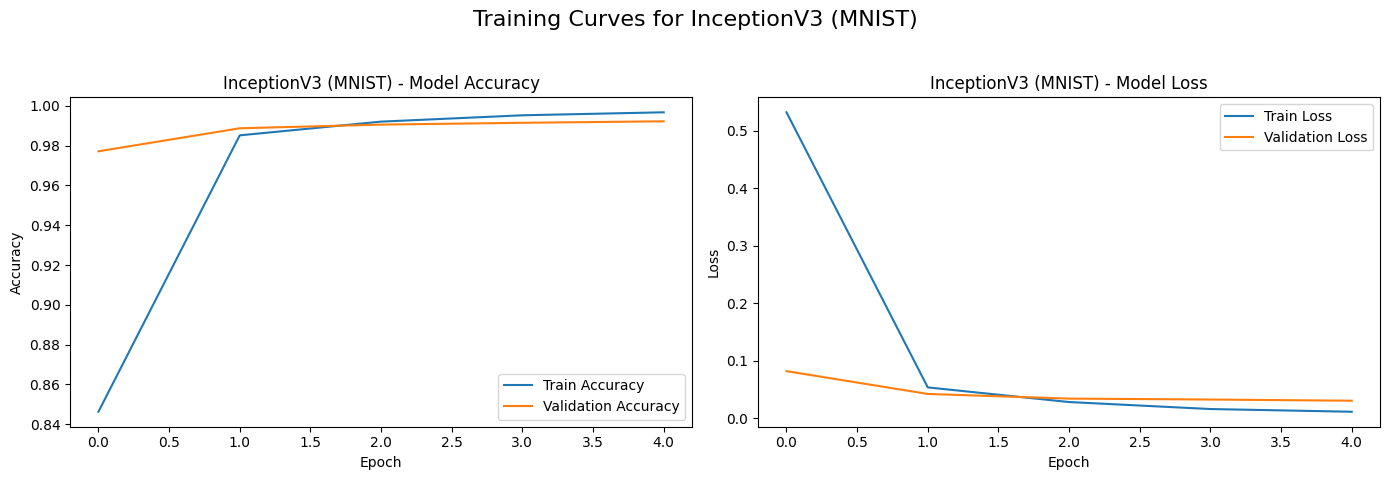

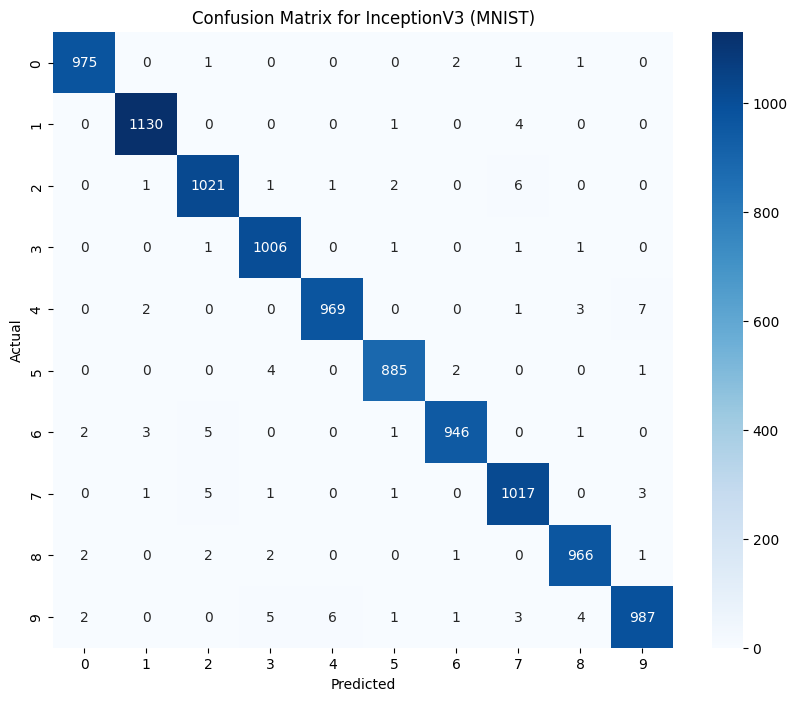

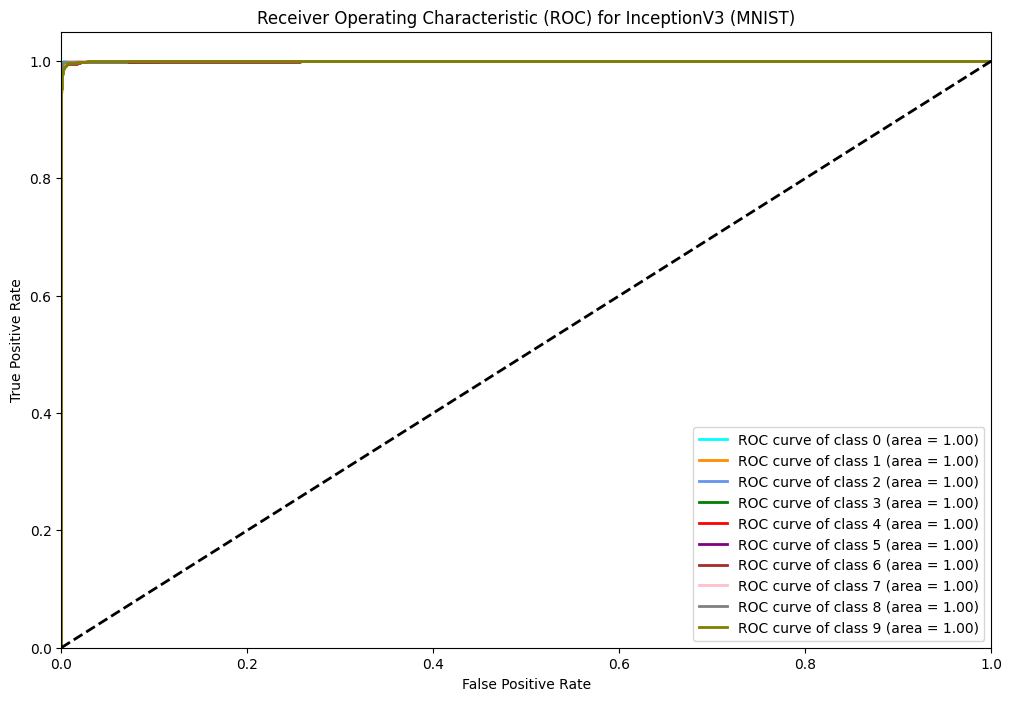

Total time for InceptionV3: 292.03 seconds


In [10]:
mnist_results['InceptionV3'] = run_mnist_experiment("InceptionV3", create_inceptionnet_model, x_train_mnist_resized75, y_train_mnist_cat, x_test_mnist_resized75, y_test_mnist_cat, input_shape=(75, 75, 3))


Running Experiment for: Custom CNN on MNIST


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.8120 - loss: 0.6354 - val_accuracy: 0.9739 - val_loss: 0.0839
Epoch 2/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9776 - loss: 0.0741 - val_accuracy: 0.9849 - val_loss: 0.0503
Epoch 3/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9856 - loss: 0.0447 - val_accuracy: 0.9861 - val_loss: 0.0468
Epoch 4/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9890 - loss: 0.0364 - val_accuracy: 0.9871 - val_loss: 0.0442
Epoch 5/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9909 - loss: 0.0291 - val_accuracy: 0.9881 - val_loss: 0.0373

Custom CNN Test Accuracy: 98.98%
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


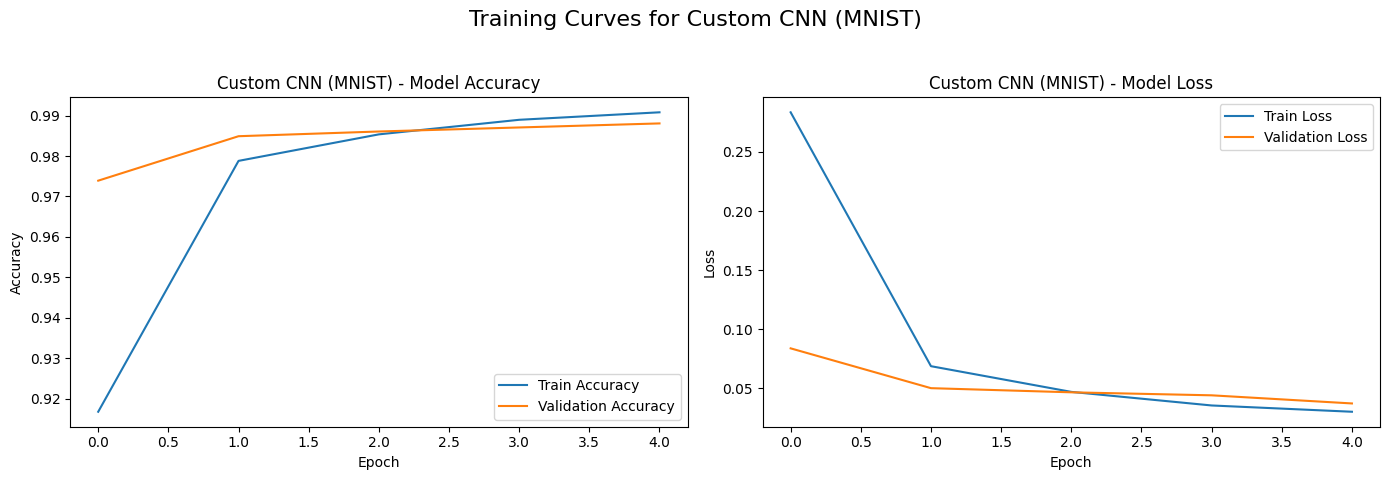

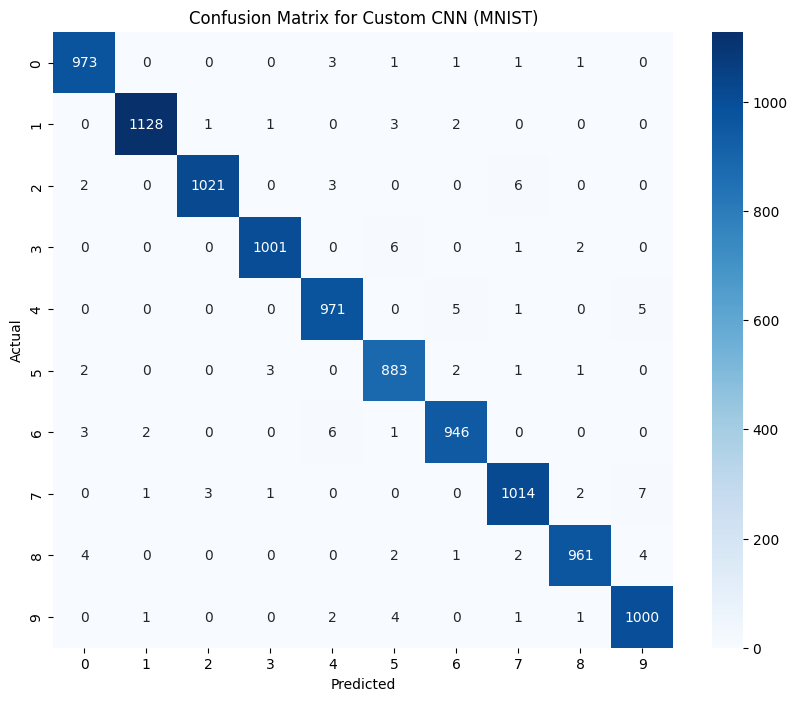

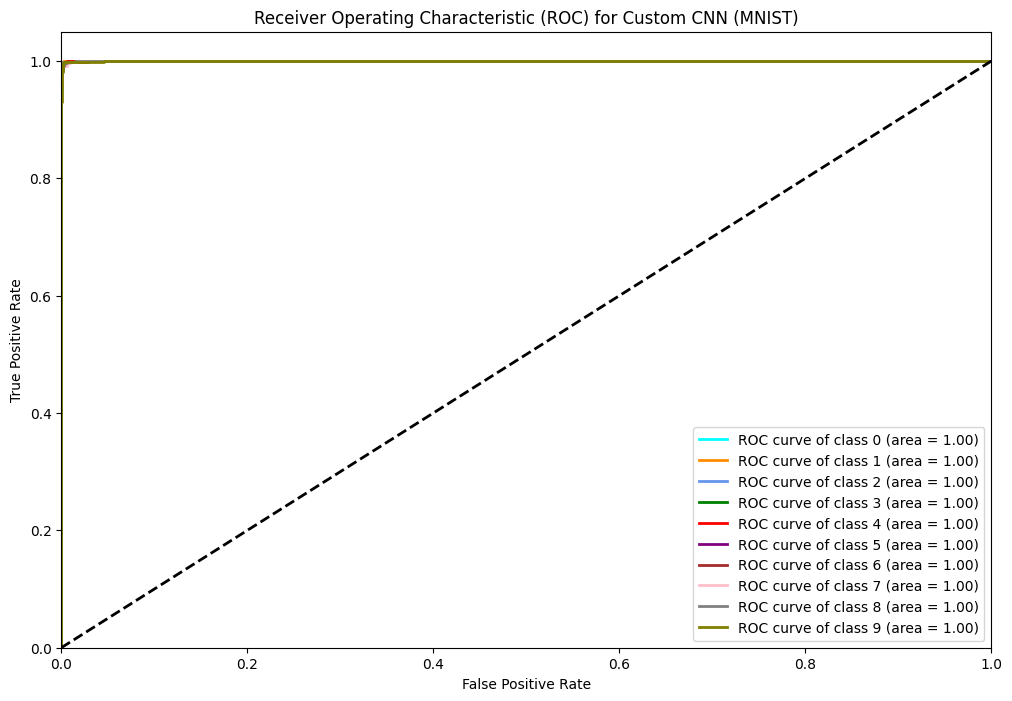

Total time for Custom CNN: 18.42 seconds


In [11]:
mnist_results['Custom CNN'] = run_mnist_experiment("Custom CNN", create_custom_cnn, x_train_mnist_cnn, y_train_mnist_cat, x_test_mnist_cnn, y_test_mnist_cat, input_shape=(28, 28, 1))


Running Experiment for: RNN on MNIST


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.7408 - loss: 0.8358 - val_accuracy: 0.9246 - val_loss: 0.2520
Epoch 2/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9287 - loss: 0.2392 - val_accuracy: 0.9510 - val_loss: 0.1694
Epoch 3/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9524 - loss: 0.1648 - val_accuracy: 0.9542 - val_loss: 0.1585
Epoch 4/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9561 - loss: 0.1542 - val_accuracy: 0.9638 - val_loss: 0.1267
Epoch 5/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9643 - loss: 0.1220 - val_accuracy: 0.9654 - val_loss: 0.1188

RNN Test Accuracy: 96.37%
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


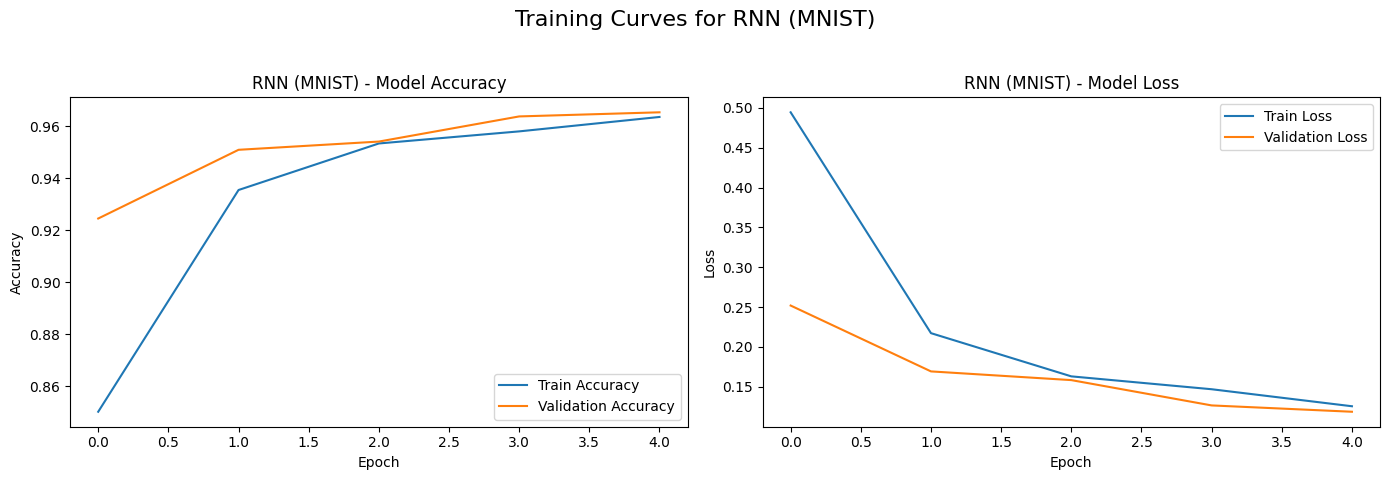

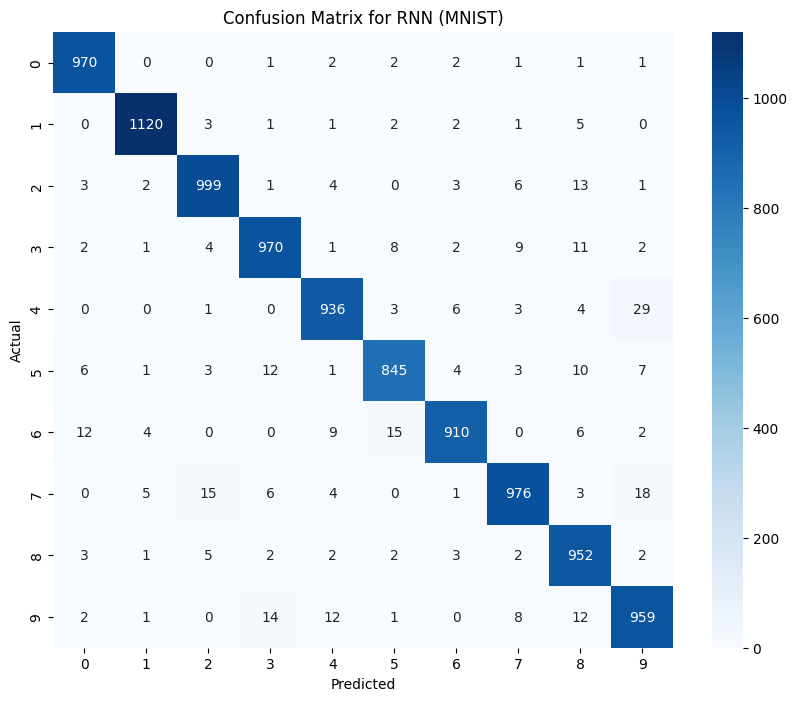

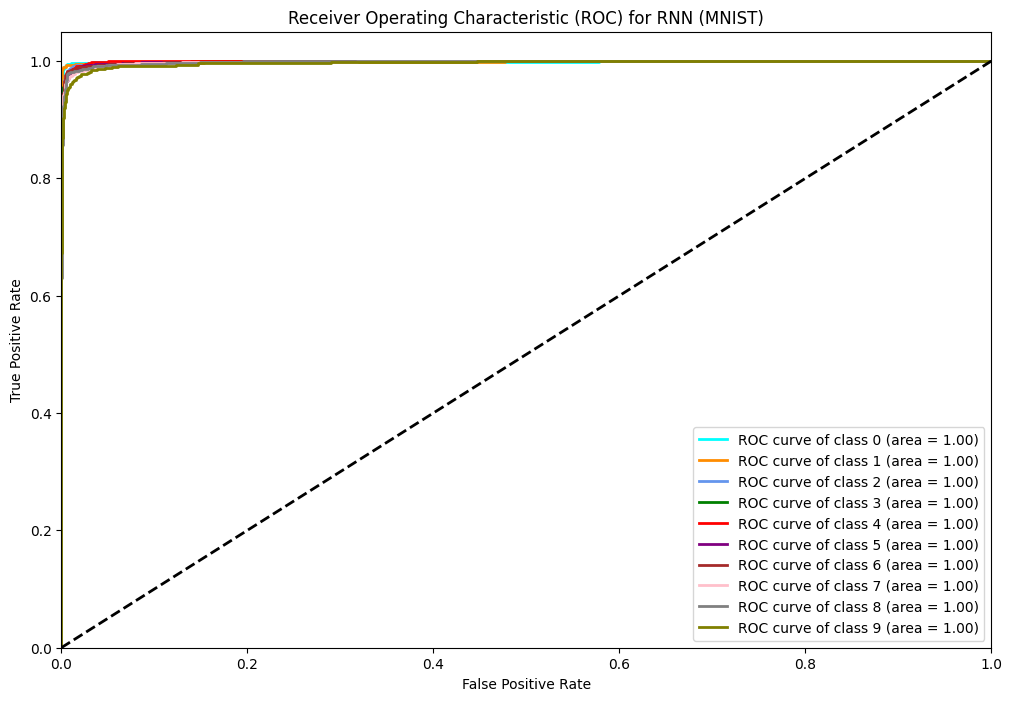

Total time for RNN: 17.17 seconds


In [12]:
mnist_results['RNN'] = run_mnist_experiment("RNN", create_rnn_mnist, x_train_mnist_std, y_train_mnist_cat, x_test_mnist_std, y_test_mnist_cat, input_shape=(28, 28))



Running Experiment for: VGG-16 on MNIST
Epoch 1/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 77s 151ms/step - accuracy: 0.1139 - loss: 2.3017 - val_accuracy: 0.1060 - val_loss: 2.3020
Epoch 2/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 48s 129ms/step - accuracy: 0.1162 - loss: 2.3010 - val_accuracy: 0.1060 - val_loss: 2.3022
Epoch 3/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 48s 128ms/step - accuracy: 0.1124 - loss: 2.3010 - val_accuracy: 0.1060 - val_loss: 2.3021
Epoch 4/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 48s 128ms/step - accuracy: 0.1129 - loss: 2.3012 - val_accuracy: 0.1060 - val_loss: 2.3023
Epoch 5/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 48s 128ms/step - accuracy: 0.1123 - loss: 2.3014 - val_accuracy: 0.1060 - val_loss: 2.3025

VGG-16 Test Accuracy: 11.35%
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step


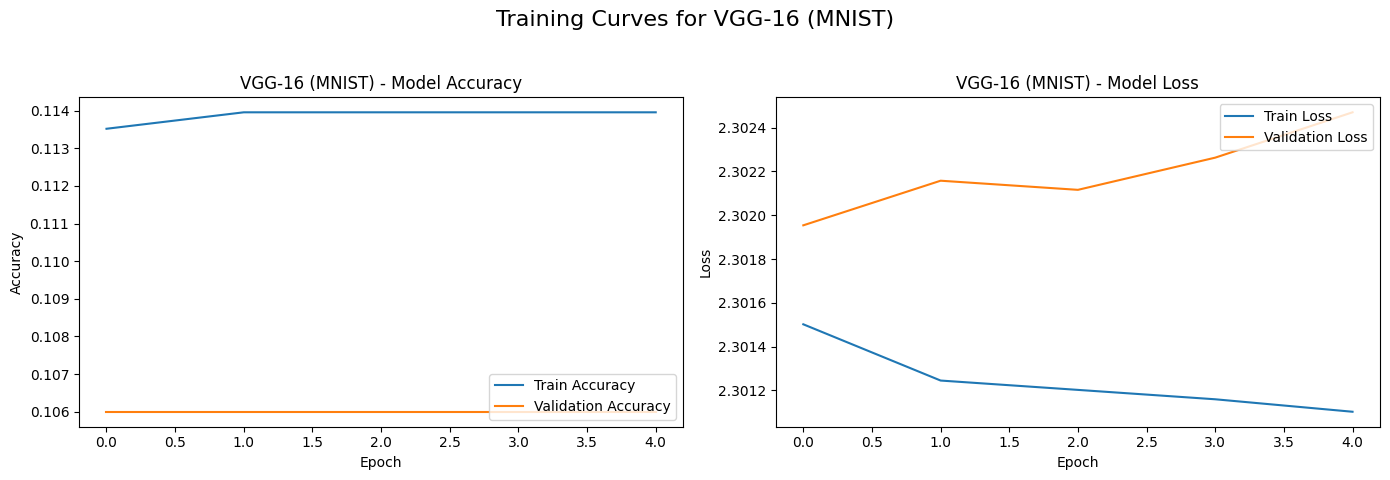

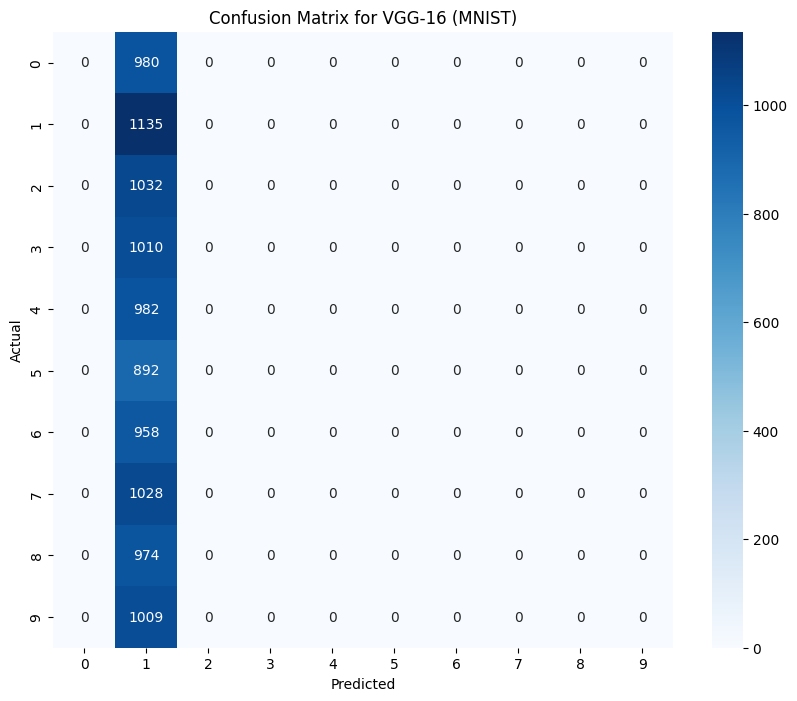

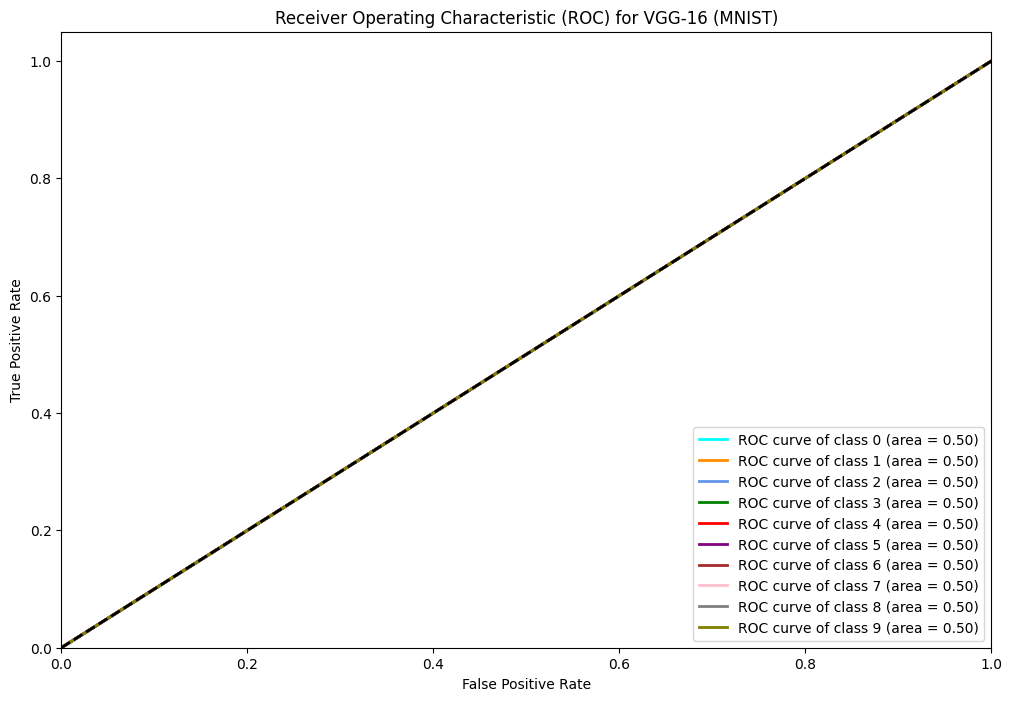

Total time for VGG-16: 288.78 seconds


In [13]:
mnist_results['VGG-16'] = run_mnist_experiment("VGG-16", create_vgg16_mnist, x_train_mnist_resized, y_train_mnist_cat, x_test_mnist_resized, y_test_mnist_cat, input_shape=(48, 48, 3))



Running Experiment for: AlexNet on MNIST


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 64s 126ms/step - accuracy: 0.8477 - loss: 0.5021 - val_accuracy: 0.9548 - val_loss: 0.3922
Epoch 2/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 40s 106ms/step - accuracy: 0.9858 - loss: 0.0462 - val_accuracy: 0.9889 - val_loss: 0.0345
Epoch 3/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 40s 107ms/step - accuracy: 0.9893 - loss: 0.0332 - val_accuracy: 0.9923 - val_loss: 0.0274
Epoch 4/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 40s 107ms/step - accuracy: 0.9929 - loss: 0.0222 - val_accuracy: 0.9939 - val_loss: 0.0236
Epoch 5/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 40s 107ms/step - accuracy: 0.9937 - loss: 0.0208 - val_accuracy: 0.9927 - val_loss: 0.0288

AlexNet Test Accuracy: 99.37%
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step


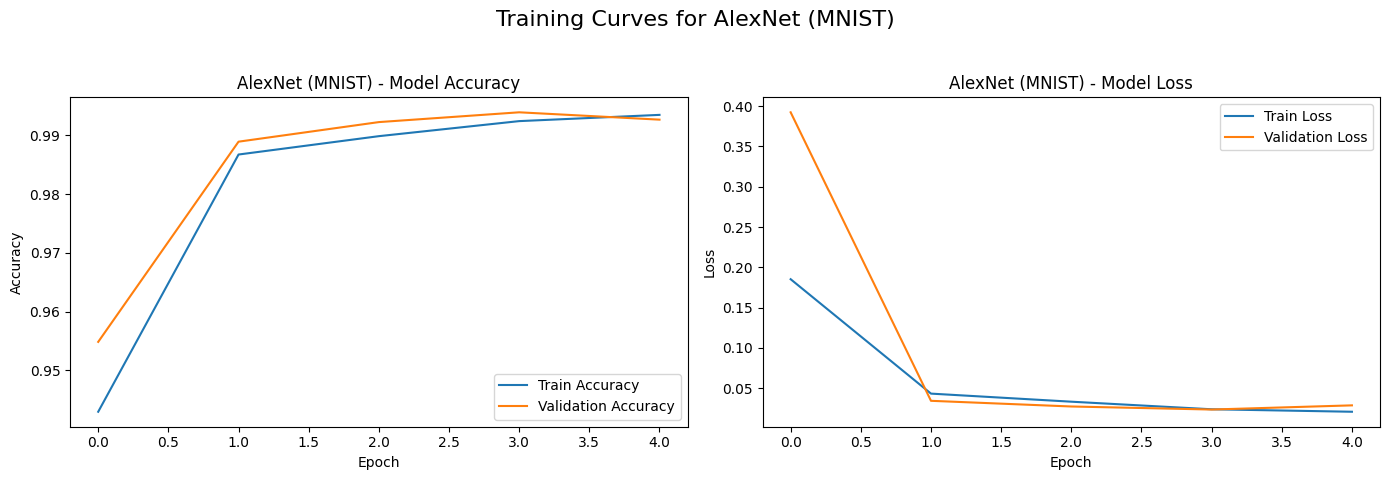

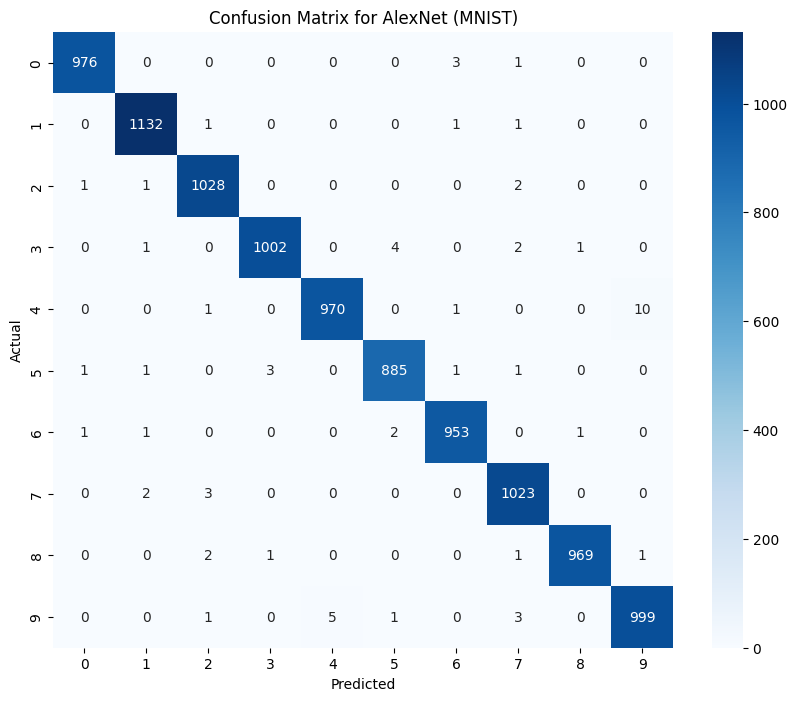

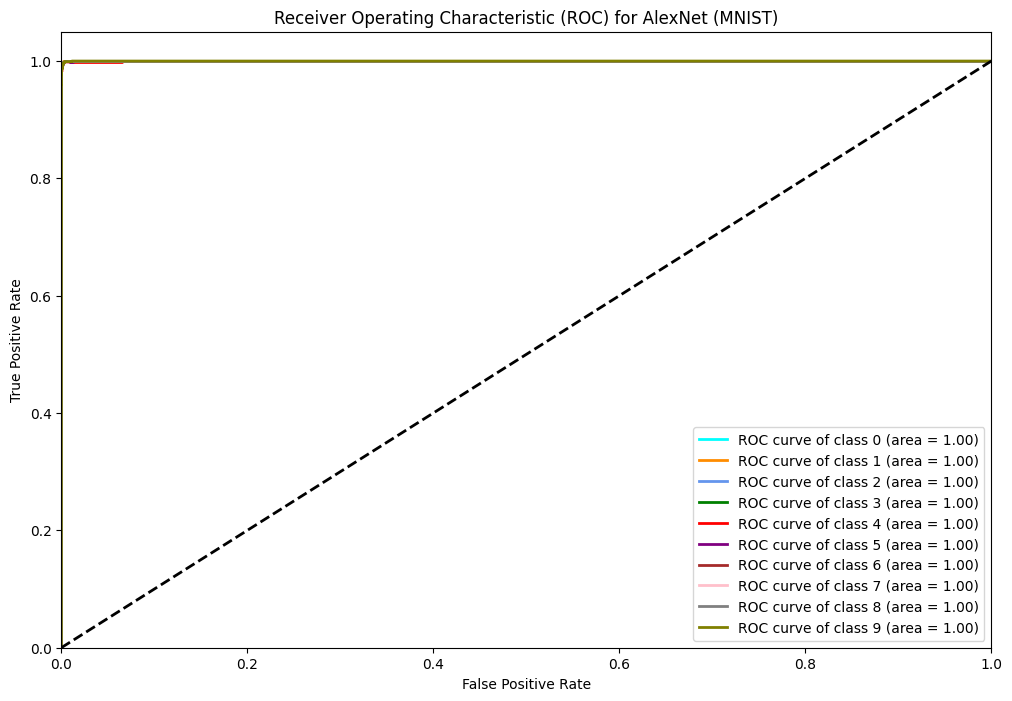

Total time for AlexNet: 242.68 seconds


In [14]:
mnist_results['AlexNet'] = run_mnist_experiment("AlexNet", create_alexnet_mnist, x_train_mnist_resized, y_train_mnist_cat, x_test_mnist_resized, y_test_mnist_cat, input_shape=(48, 48, 3))


In [15]:
# mnist_results['InceptionV3'] = run_mnist_experiment("InceptionV3", create_inceptionnet_model, x_train_mnist_resized75, y_train_mnist_cat, x_test_mnist_resized75, y_test_mnist_cat, input_shape=(75, 75, 3))

In [16]:
# ==============================================================================
# CELL 5: CIFAR-10 DATA PREPARATION
# ==============================================================================
(x_train_cifar, y_train_cifar), (x_test_cifar, y_test_cifar) = cifar10.load_data()

# Preprocessing for standard CNN/AlexNet/GoogLeNet
# Normalize pixel values
x_train_cifar_std = x_train_cifar.astype('float32') / 255.0
x_test_cifar_std = x_test_cifar.astype('float32') / 255.0

# Preprocessing for RNN
# We will reshape the 32x32x3 image into a 32x96 sequence
x_train_cifar_rnn = x_train_cifar_std.reshape(x_train_cifar_std.shape[0], 32, 32 * 3)
x_test_cifar_rnn = x_test_cifar_std.reshape(x_test_cifar_std.shape[0], 32, 32 * 3)


# --- Preprocessing for VGG16 ---
# VGG16 expects larger images, so we'll resize
x_train_cifar_resized = tf.image.resize(x_train_cifar_std, [48, 48]).numpy()
x_test_cifar_resized = tf.image.resize(x_test_cifar_std, [48, 48]).numpy()

# encode the labels
y_train_cifar_cat = to_categorical(y_train_cifar, 10)
y_test_cifar_cat = to_categorical(y_test_cifar, 10)

cifar_class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

print("CIFAR-10 Data Shapes:")
print("Standard Train:", x_train_cifar_std.shape)
print("RNN Train:", x_train_cifar_rnn.shape)
print("Resized for VGG Train:", x_train_cifar_resized.shape)

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
CIFAR-10 Data Shapes:
Standard Train: (50000, 32, 32, 3)
RNN Train: (50000, 32, 96)
Resized for VGG Train: (50000, 48, 48, 3)


In [21]:
# ==============================================================================
# CELL 6: CIFAR-10 MODEL DEFINITIONS
# ==============================================================================
def create_rnn_cifar(input_shape=(32, 96)):
    model = models.Sequential([
        layers.SimpleRNN(128, input_shape=input_shape),
        layers.Dense(10, activation='softmax')
    ])
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model


Running Experiment for: Custom CNN on CIFAR-10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.3053 - loss: 1.8898 - val_accuracy: 0.4759 - val_loss: 1.4485
Epoch 2/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.4900 - loss: 1.4216 - val_accuracy: 0.5305 - val_loss: 1.3137
Epoch 3/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5424 - loss: 1.2815 - val_accuracy: 0.5588 - val_loss: 1.2659
Epoch 4/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.5935 - loss: 1.1493 - val_accuracy: 0.6044 - val_loss: 1.1341
Epoch 5/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6252 - loss: 1.0783 - val_accuracy: 0.6162 - val_loss: 1.0874

Custom CNN Test Accuracy: 62.39%
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


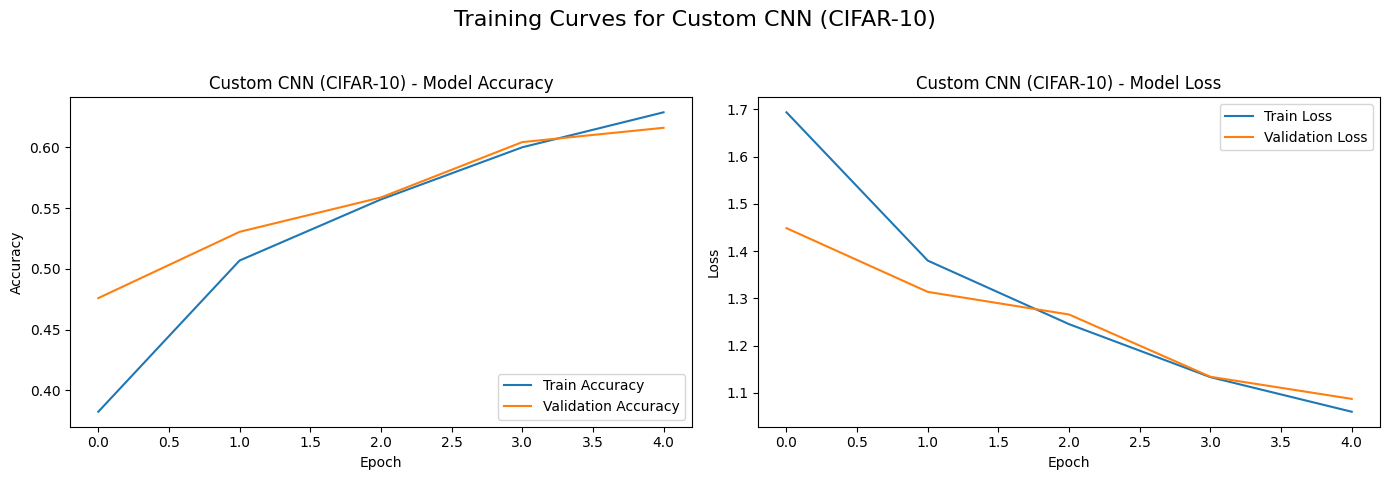

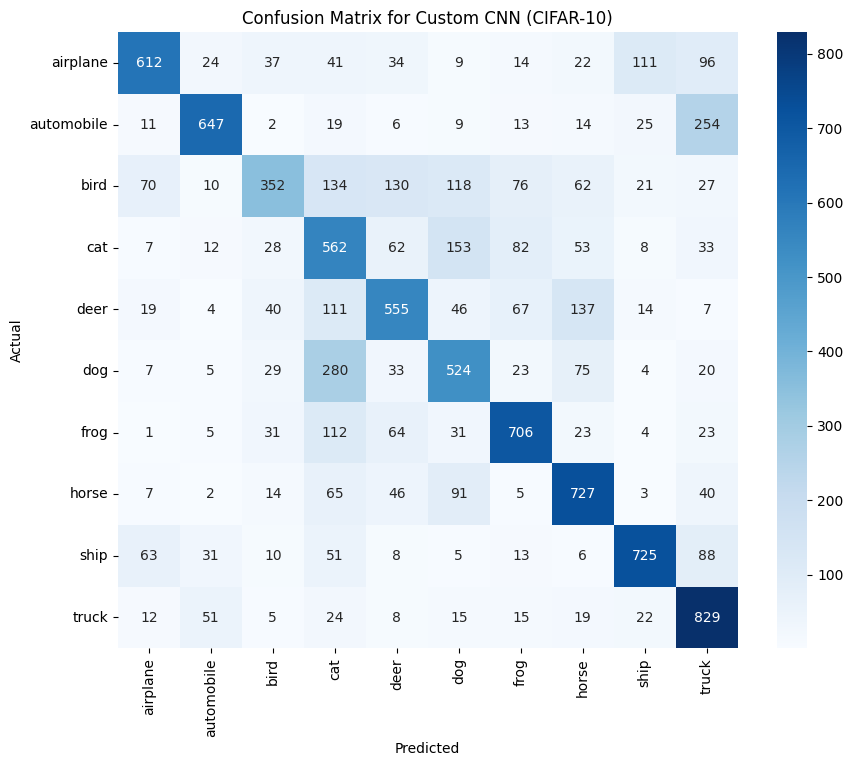

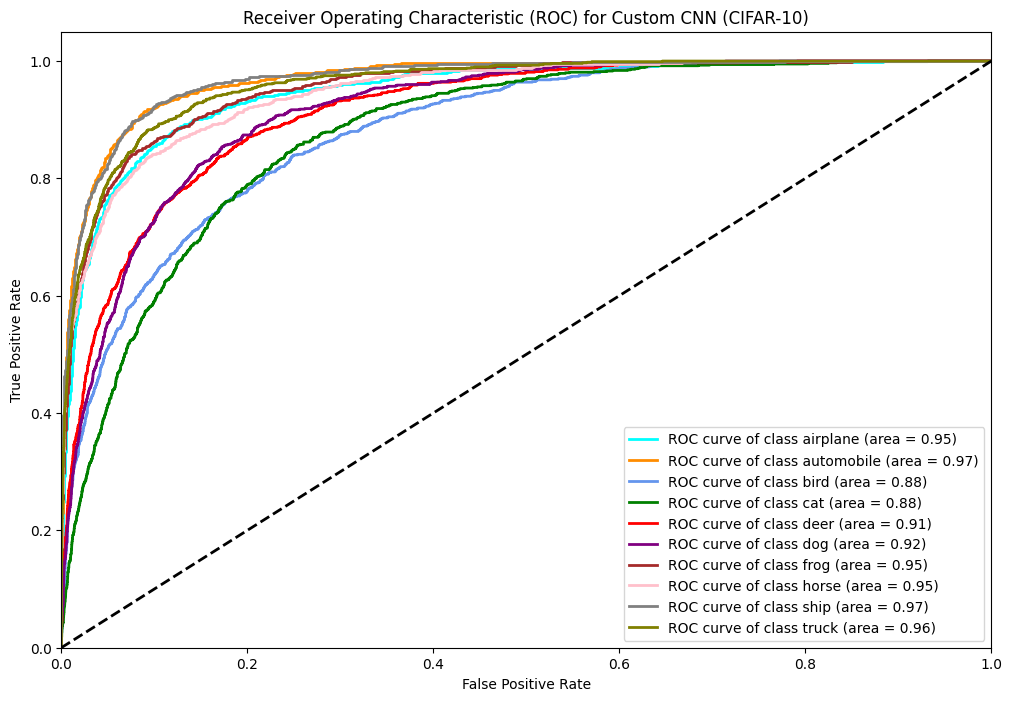

Total time for Custom CNN: 19.56 seconds

Running Experiment for: RNN on CIFAR-10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.2291 - loss: 2.0917 - val_accuracy: 0.2573 - val_loss: 2.0514
Epoch 2/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.2945 - loss: 1.9123 - val_accuracy: 0.3393 - val_loss: 1.7889
Epoch 3/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.3410 - loss: 1.7964 - val_accuracy: 0.3465 - val_loss: 1.7931
Epoch 4/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.3546 - loss: 1.7528 - val_accuracy: 0.3701 - val_loss: 1.7553
Epoch 5/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.3715 - loss: 1.7129 - val_accuracy: 0.3876 - val_loss: 1.7074

RNN Test Accuracy: 38.11%
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step


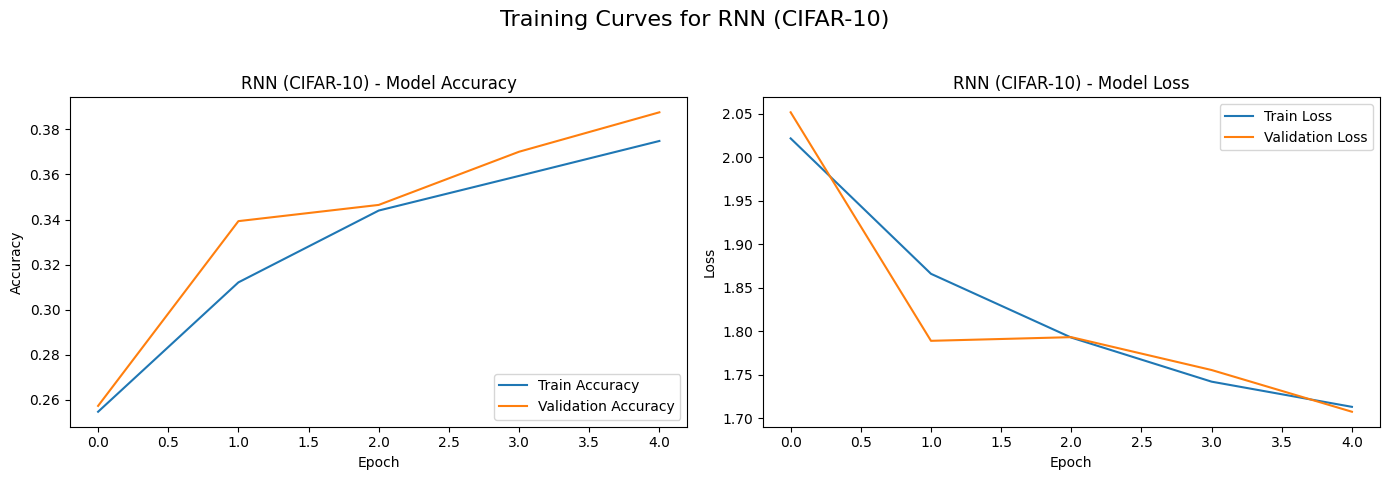

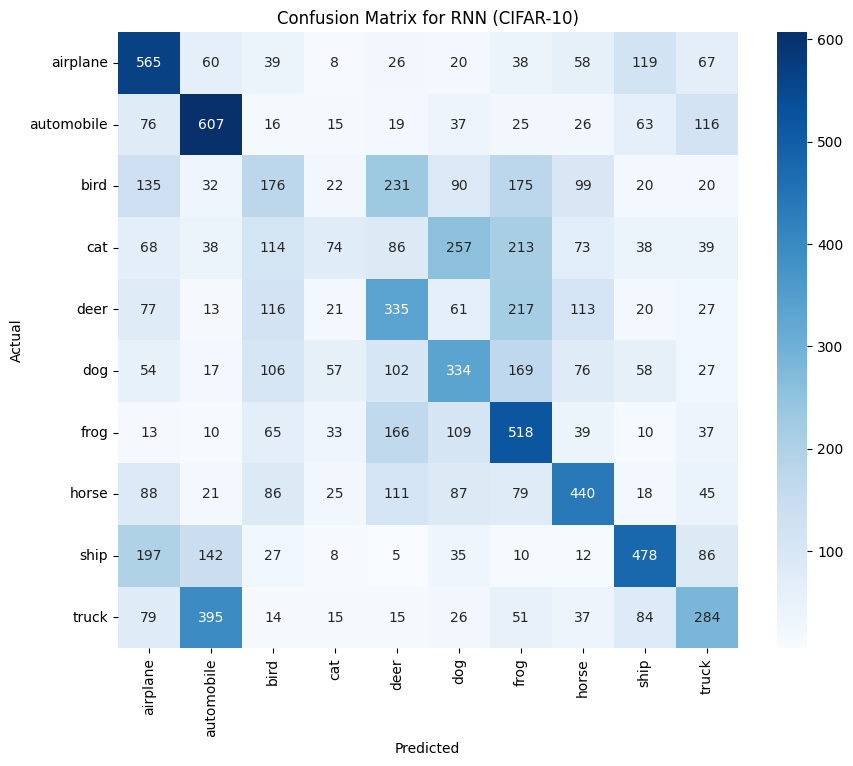

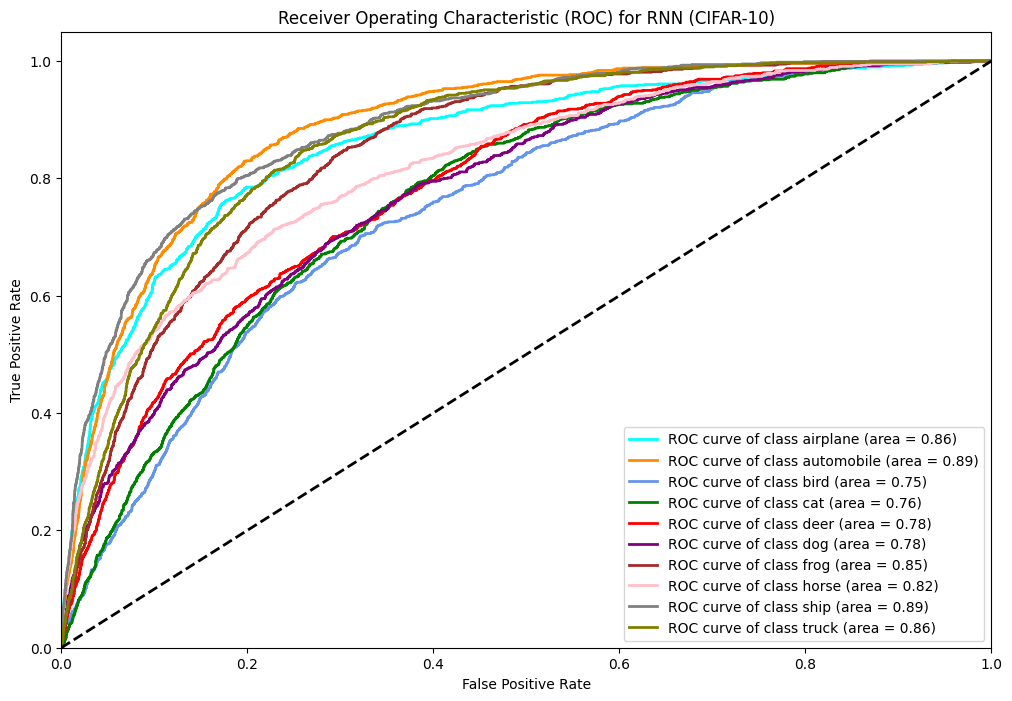

Total time for RNN: 20.62 seconds

Running Experiment for: VGG-16 on CIFAR-10
Epoch 1/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 55s 146ms/step - accuracy: 0.0962 - loss: 2.3185 - val_accuracy: 0.0980 - val_loss: 2.3027
Epoch 2/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 40s 129ms/step - accuracy: 0.1020 - loss: 2.3026 - val_accuracy: 0.0952 - val_loss: 2.3027
Epoch 3/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 41s 130ms/step - accuracy: 0.0984 - loss: 2.3026 - val_accuracy: 0.1016 - val_loss: 2.3027
Epoch 4/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 40s 129ms/step - accuracy: 0.0995 - loss: 2.3026 - val_accuracy: 0.0952 - val_loss: 2.3027
Epoch 5/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 40s 129ms/step - accuracy: 0.1013 - loss: 2.3027 - val_accuracy: 0.0952 - val_loss: 2.3028

VGG-16 Test Accuracy: 10.00%
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step


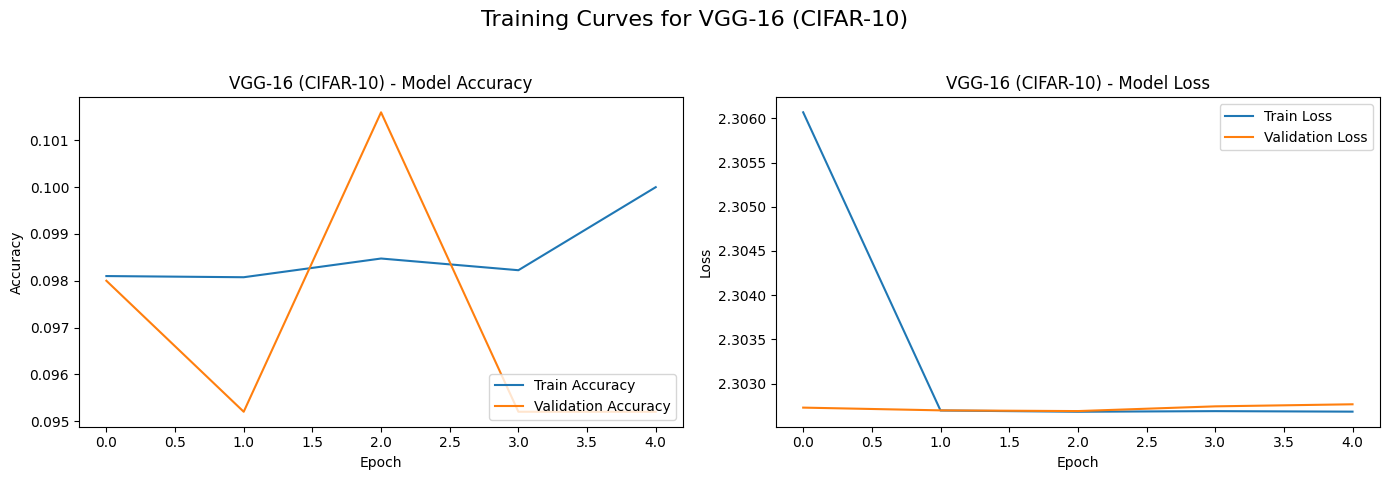

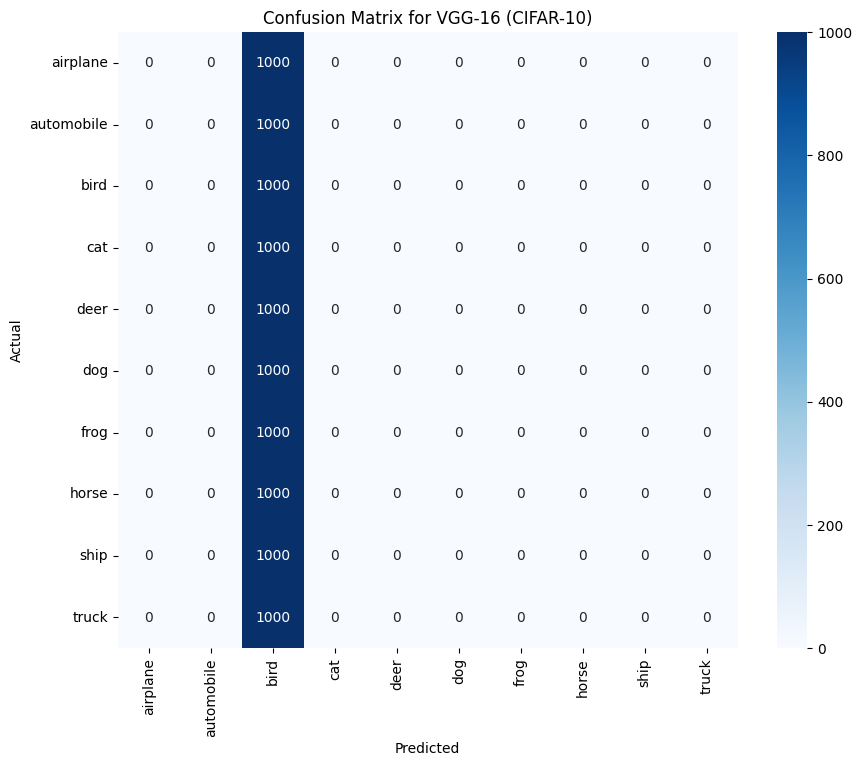

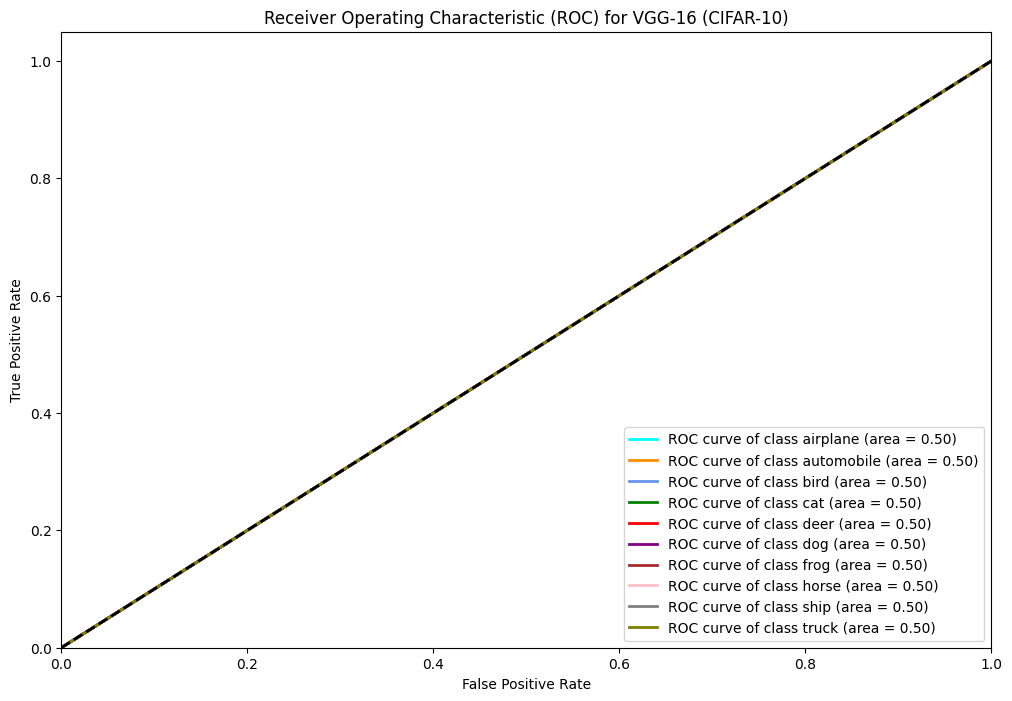

Total time for VGG-16: 232.51 seconds

Running Experiment for: AlexNet on CIFAR-10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 44s 102ms/step - accuracy: 0.3504 - loss: 1.7777 - val_accuracy: 0.1556 - val_loss: 2.5732
Epoch 2/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 21s 68ms/step - accuracy: 0.6138 - loss: 1.0797 - val_accuracy: 0.6298 - val_loss: 1.0370
Epoch 3/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 21s 68ms/step - accuracy: 0.7129 - loss: 0.8138 - val_accuracy: 0.6772 - val_loss: 0.9471
Epoch 4/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 21s 68ms/step - accuracy: 0.7767 - loss: 0.6441 - val_accuracy: 0.7147 - val_loss: 0.8537
Epoch 5/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 21s 68ms/step - accuracy: 0.8287 - loss: 0.5002 - val_accuracy: 0.7268 - val_loss: 0.8374

AlexNet Test Accuracy: 72.58%
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step


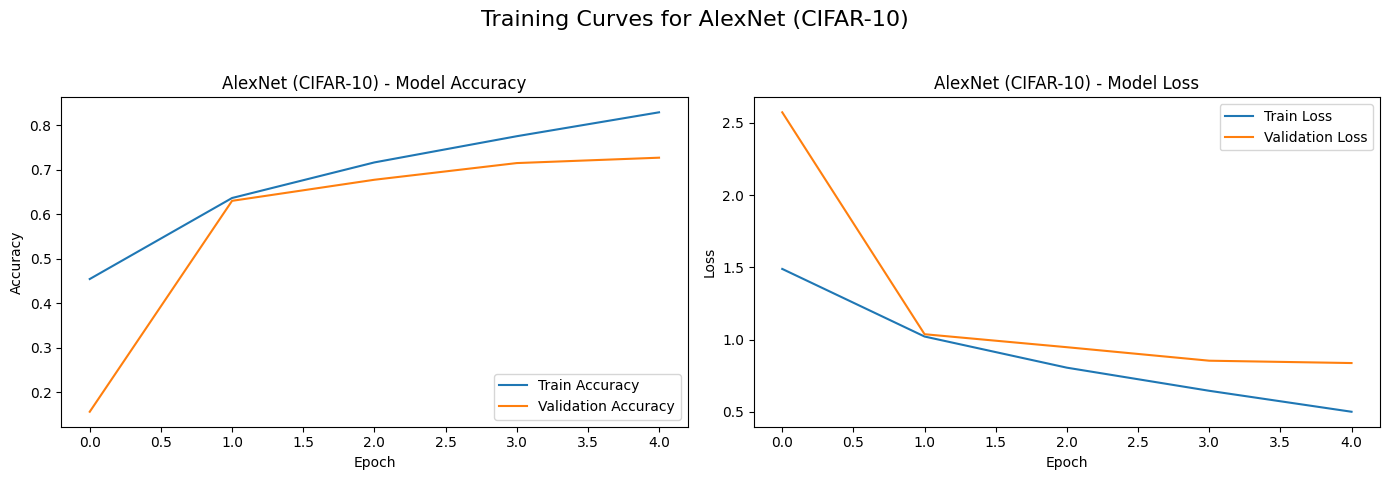

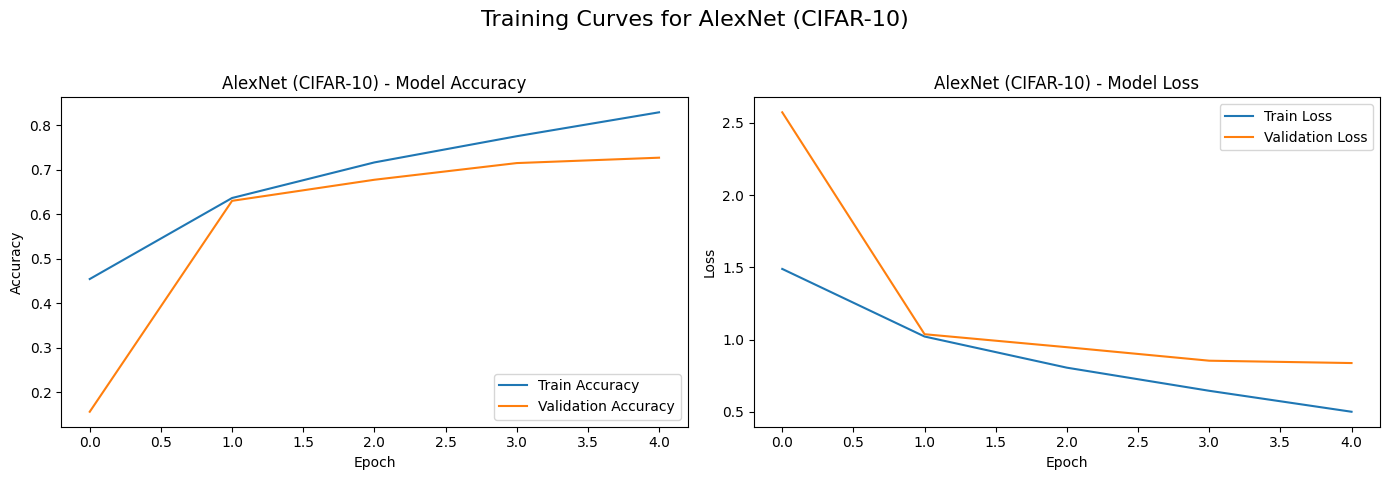

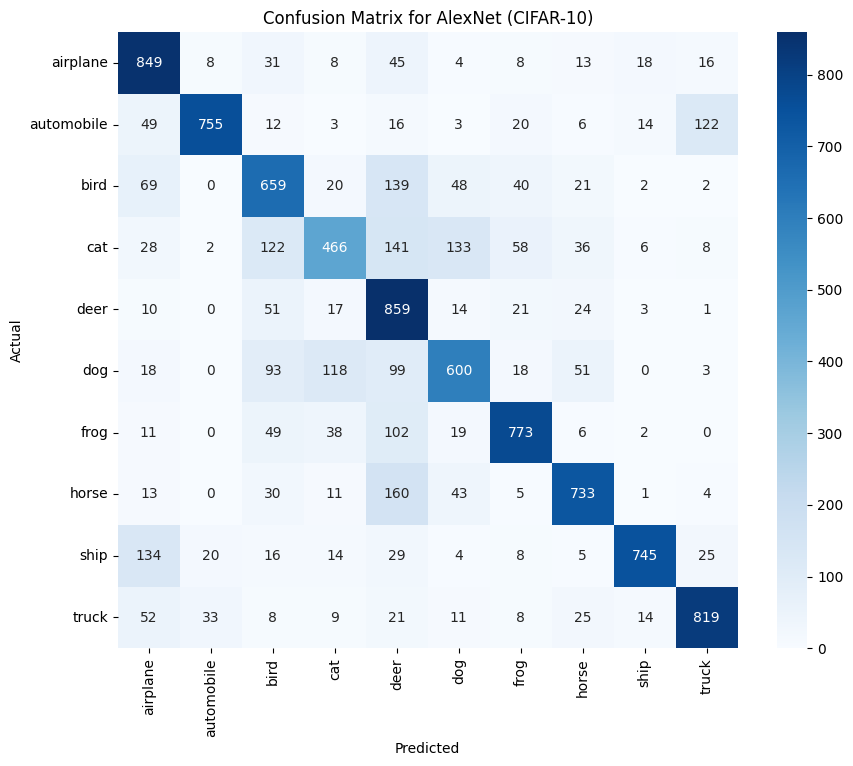

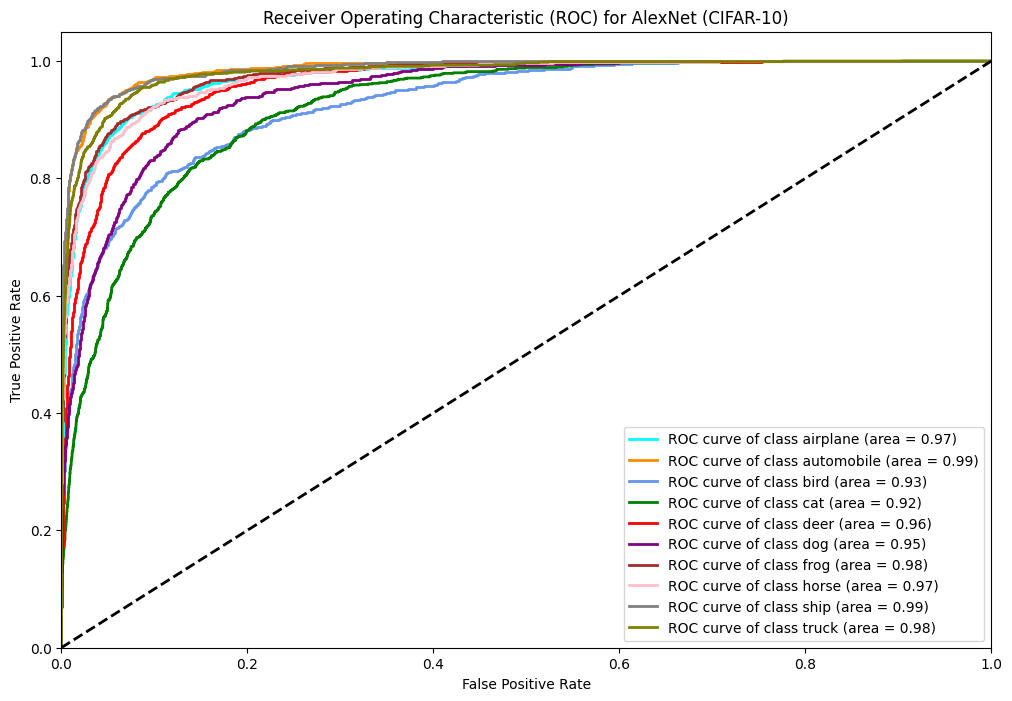

Total time for AlexNet: 139.70 seconds

Running Experiment for: GoogLeNet on CIFAR-10


ValueError: Input size must be at least 75x75; Received: input_shape=(32, 32, 3)

In [22]:
# ==============================================================================
# CELL 7: CIFAR-10 TRAINING & EVALUATION
# ==============================================================================
CIFAR_EPOCHS = 5

# --- Function to run the full pipeline for a model on CIFAR-10 ---
def run_cifar_experiment(model_name, model_fn, train_data, train_labels, test_data, test_labels, epochs=CIFAR_EPOCHS, input_shape=None):
    print(f"\n{'='*30}\nRunning Experiment for: {model_name} on CIFAR-10\n{'='*30}")
    start_time = time.time()

    # Create model
    if input_shape:
        model = model_fn(input_shape=input_shape)
    else:
        model = model_fn()

    # Train model
    history = model.fit(train_data, train_labels,
                        epochs=epochs,
                        batch_size=BATCH_SIZE,
                        validation_split=0.2, # 80/20 split
                        verbose=1)

    # Evaluate test set
    loss, accuracy = model.evaluate(test_data, test_labels, verbose=0)
    print(f"\n{model_name} Test Accuracy: {accuracy*100:.2f}%")

    # Generate predictions
    y_pred_proba = model.predict(test_data)
    y_pred_classes = np.argmax(y_pred_proba, axis=1)
    y_true = np.argmax(test_labels, axis=1)

    # Plot results
    plot_history(history, f"{model_name} (CIFAR-10)")
    plot_confusion_matrix(y_true, y_pred_classes, cifar_class_names, f"{model_name} (CIFAR-10)")
    plot_roc_auc(y_true, y_pred_proba, 10, cifar_class_names, f"{model_name} (CIFAR-10)")

    end_time = time.time()
    print(f"Total time for {model_name}: {end_time - start_time:.2f} seconds")
    return accuracy

# Run experiments for all models
cifar_results = {}

cifar_results['Custom CNN'] = run_cifar_experiment("Custom CNN", create_custom_cnn, x_train_cifar_std, y_train_cifar_cat, x_test_cifar_std, y_test_cifar_cat, input_shape=(32, 32, 3))
cifar_results['RNN (LSTM)'] = run_cifar_experiment("RNN", create_rnn_cifar, x_train_cifar_rnn, y_train_cifar_cat, x_test_cifar_rnn, y_test_cifar_cat, input_shape=(32, 96))
cifar_results['VGG-16'] = run_cifar_experiment("VGG-16", create_vgg16_mnist, x_train_cifar_resized, y_train_cifar_cat, x_test_cifar_resized, y_test_cifar_cat, input_shape=(48, 48, 3))
cifar_results['AlexNet'] = run_cifar_experiment("AlexNet", create_alexnet_mnist, x_train_cifar_std, y_train_cifar_cat, x_test_cifar_std, y_test_cifar_cat, input_shape=(32, 32, 3))
cifar_results['GoogLeNet'] = run_cifar_experiment("GoogLeNet", create_inceptionnet_model, x_train_cifar_std, y_train_cifar_cat, x_test_cifar_std, y_test_cifar_cat, input_shape=(32, 32, 3))


Running Experiment for: InceptionNetV3 on CIFAR-10
Epoch 1/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 114s 211ms/step - accuracy: 0.3521 - loss: 1.8327 - val_accuracy: 0.6937 - val_loss: 0.9005
Epoch 2/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 30s 95ms/step - accuracy: 0.7592 - loss: 0.7013 - val_accuracy: 0.7928 - val_loss: 0.6149
Epoch 3/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 30s 95ms/step - accuracy: 0.8570 - loss: 0.4187 - val_accuracy: 0.8129 - val_loss: 0.5629
Epoch 4/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 29s 93ms/step - accuracy: 0.9047 - loss: 0.2856 - val_accuracy: 0.8242 - val_loss: 0.5617
Epoch 5/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 30s 95ms/step - accuracy: 0.9414 - loss: 0.1864 - val_accuracy: 0.8241 - val_loss: 0.5897

InceptionNetV3 Test Accuracy: 82.09%
313/313 ━━━━━━━━━━━━━━━━━━━━ 18s 36ms/step


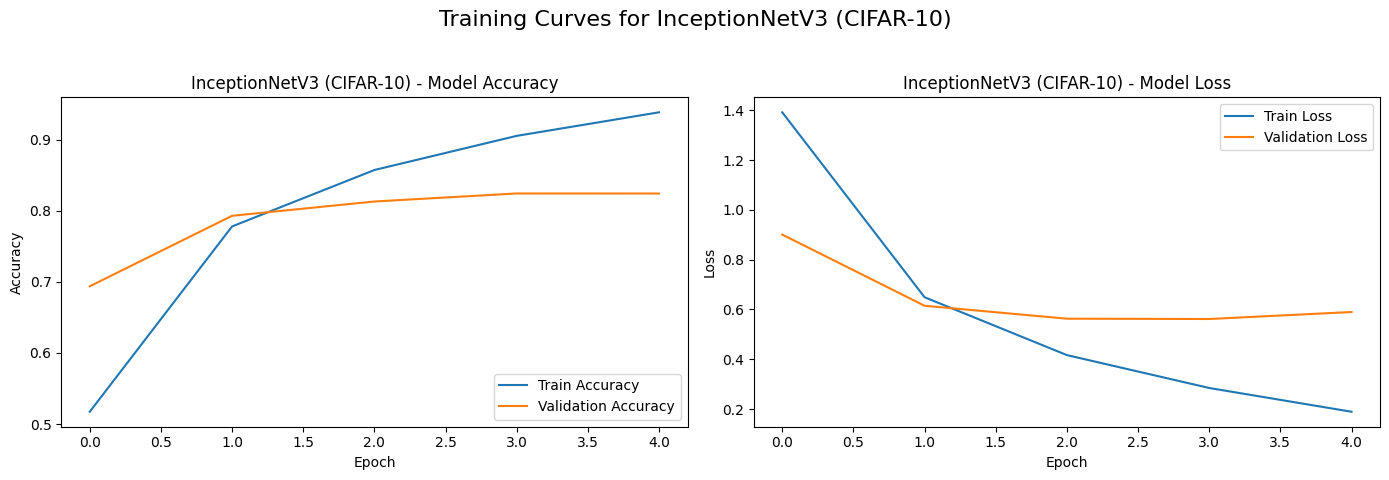

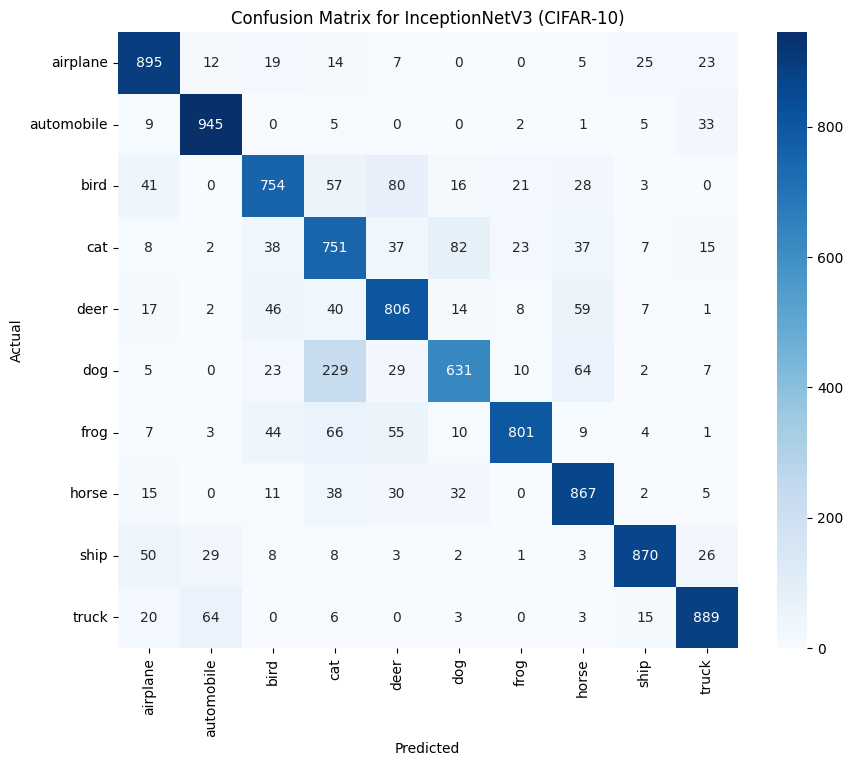

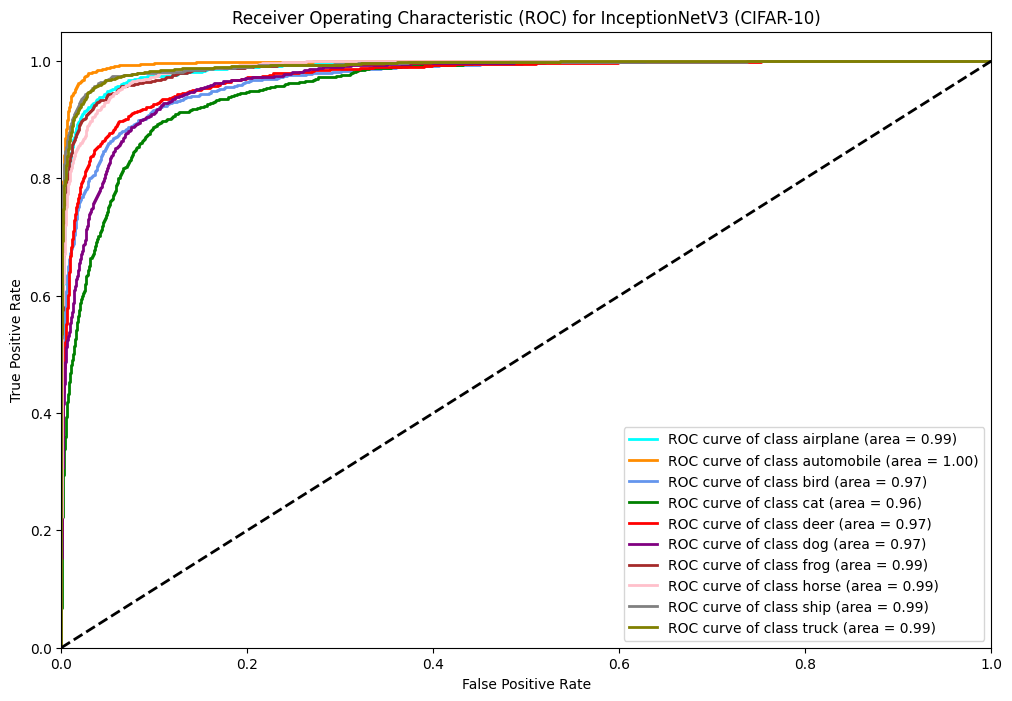

Total time for InceptionNetV3: 271.60 seconds


In [27]:
x_train_cifar_resized75 = tf.image.resize(x_train_cifar_std, [75, 75]).numpy()
x_test_cifar_resized75 = tf.image.resize(x_test_cifar_std, [75, 75]).numpy()

cifar_results['InceptionNetV3'] = run_cifar_experiment("InceptionNetV3", create_inceptionnet_model, x_train_cifar_resized75, y_train_cifar_cat, x_test_cifar_resized75, y_test_cifar_cat, input_shape=(75,75, 3))

In [28]:
# ==============================================================================
# CELL 8: FINAL COMPARISON
# ==============================================================================
import pandas as pd

# Create a DataFrame for easy viewing
df_results = pd.DataFrame({
    'Model': list(mnist_results.keys()),
    'MNIST Test Accuracy': [f"{acc*100:.2f}%" for acc in mnist_results.values()],
    'CIFAR-10 Test Accuracy': [f"{acc*100:.2f}%" for acc in cifar_results.values()]
})

print("\n\n--- FINAL PERFORMANCE COMPARISON ---")
print(df_results.to_string(index=False))



--- FINAL PERFORMANCE COMPARISON ---
      Model MNIST Test Accuracy CIFAR-10 Test Accuracy
InceptionV3              99.02%                 62.39%
 Custom CNN              98.98%                 38.11%
        RNN              96.37%                 10.00%
     VGG-16              11.35%                 72.58%
    AlexNet              99.37%                 82.09%
